# Load and setup the data and variables

In [52]:
expr_mouse = "../../data/prepared/mouse_scaled.tsv.gz"
mean_mouse_out = "../../data/prepared/mouse_meaned.tsv.gz"
mouse_results_out = "../../data/prepared/mouse_results.tsv.gz"
expr_human = "../../data/prepared/human_scaled.tsv.gz"
mean_human_out = "../../data/prepared/human_meaned.tsv.gz"
human_results_out = "../../data/prepared/human_results.tsv.gz"
conservation = "../../data/prepared/aucs.tsv.gz"

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn import preprocessing, decomposition

In [3]:
aurocs = pd.read_csv(conservation, sep="\t", index_col=0).mean(axis=1)
aurocs.rename('auroc', inplace=True)

SLC39A1    0.521690
SCAMP2     0.247573
LYRM7      0.546687
SYVN1      0.420172
SHC4       0.272679
             ...   
DOCK9      0.258718
PLXNB2     0.272631
RGS8       0.399987
CCNO       0.499295
ACOT7      0.296424
Name: auroc, Length: 11139, dtype: float64

In [4]:
mouse = pd.read_csv(expr_mouse, sep="\t", header=0, index_col=[0,1])
human = pd.read_csv(expr_human, sep="\t", header=0, index_col=[0,1])
mouse.head().iloc[:,:5]

Xkr4     Gm1992    Gm37381        Rp1     Mrpl15
celltype donor_id                                                        
E_1      F003      150.431298  96.168484   5.888929  23.691612  77.763569
         F004      146.923587  88.845963  13.489568  21.113059  83.094336
         F005      155.846667  99.615089  10.187479  25.548710  78.363895
         F006      152.220075  93.619603   7.656298  22.170951  80.374269
         F007      156.802103  96.535744   3.521052  29.365177  78.778955

In [5]:
mouse.shape

(280, 19074)

In [6]:
human.shape

(111, 12383)

We have to capitalize all of the mouse gene names.

In [7]:
mouse.columns = [gene.upper() for gene in mouse.columns]
human.columns = [gene.upper() for gene in human.columns]
mouse.columns

Index(['XKR4', 'GM1992', 'GM37381', 'RP1', 'MRPL15', 'LYPLA1', 'GM37988',
       'TCEA1', 'RGS20', 'GM16041',
       ...
       'MT-ND5', 'MT-ND6', 'MT-CYTB', 'VAMP7', 'SPRY3', 'TMLHE', 'AC132444.5',
       'AC149090.1', 'CAAA01118383.1', 'CAAA01147332.1'],
      dtype='object', length=19074)

We're only interested in genes that are shared between the two species.

In [8]:
genes = list(set(mouse.columns).intersection(human.columns))
len(genes)

11139

In [9]:
mouse_genes = mouse.loc[:,genes]
human_genes = human.loc[:,genes]
human_genes.shape

(111, 11139)

Let's rescale across samples now that we've excluded some genes.

In [10]:
mouse_genes = mouse_genes.divide(mouse_genes.sum(axis=1), axis=0)*1e6
human_genes = human_genes.divide(human_genes.sum(axis=1), axis=0)*1e6
mouse_genes.head().iloc[:,:5]

AMZ1      CORO2A      HRH4       AGGF1       RPL18
celltype donor_id                                                         
E_1      F003      15.658056  111.180222  8.228672  113.469875  123.817912
         F004      16.130193  108.813212  4.399754  113.150569  137.657940
         F005      21.315197  114.085051  4.881162  116.809060  124.855443
         F006      23.351969  113.345765  4.885501  115.108630  131.765384
         F007      19.172893  112.933745  2.547392  110.637641  127.888327

# Obtain the mean expression over samples in each celltype

In [11]:
mean_mouse = mouse_genes.groupby('celltype').mean().T
mean_mouse.index.names = ['gene']
mean_human = human_genes.groupby('celltype').mean().T
mean_human.index.names = ['gene']
mean_mouse.head().iloc[:,:5]

celltype,E_1,E_10,E_11,E_12,E_14
gene,,,,,
AMZ1,20.602723,24.065380,15.872772,47.789805,43.700172
CORO2A,111.308422,109.630846,126.043238,110.775401,116.058198
HRH4,5.788158,5.557802,7.388241,7.391215,5.154273
AGGF1,112.809427,107.114641,117.549738,103.535933,105.635717
RPL18,131.692282,118.451211,134.796072,117.469426,120.153002


In [12]:
mean_mouse.shape

(11139, 33)

In [13]:
mean_human.shape

(11139, 58)

Let's also merge the data into a single dataframe.

In [14]:
def merge_dfs(expr, aurocs):
    return expr.merge(aurocs, left_index=True, right_index=True)

In [15]:
full_mouse = merge_dfs(mean_mouse, aurocs)
full_human = merge_dfs(mean_human, aurocs)
full_mouse.head().iloc[:,-5:]

,N_4,N_5,N_6,N_7,auroc
AMZ1,116.041688,137.194873,47.655577,39.400734,0.305987
CORO2A,131.288012,27.136771,118.276224,35.268699,0.490355
HRH4,3.589044,3.078599,0.000000,0.000000,0.523924
AGGF1,110.904436,101.366893,124.959017,121.937470,0.534208
RPL18,143.958539,135.452754,180.410359,170.301999,0.566040


# Perform a basic regression without correcting for anything

In [16]:
def multiple_reg(expr, full_expr):
    sumstats = {}
    for celltype in expr.columns:
        model = smf.ols(formula=f"{celltype} ~ auroc", data=full_expr)
        res = model.fit()
        sumstats[celltype] = res.summary2().tables[1].loc['auroc']
    sumstats = pd.DataFrame(sumstats).T
    sumstats.index.names = ['celltype']
    sumstats.columns = ['beta', 'stderr', 't', 'pval', 'CI_start', 'CI_end']
    return sumstats

In [17]:
mouse_res = multiple_reg(mean_mouse, full_mouse)
mouse_res.head()

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,82.423015,3.996945,20.621505,9.396040e-93,74.588296,90.257734
E_10,76.551882,3.962917,19.317055,8.349462e-82,68.783863,84.319900
E_11,84.058203,4.146791,20.270662,9.610085e-90,75.929758,92.186647
E_12,73.141438,4.092515,17.872003,1.870087e-70,65.119384,81.163492
E_14,76.397451,3.964780,19.269026,2.051700e-81,68.625780,84.169122


In [59]:
human_res['pval'] < 0.05

celltype
E_1     True
E_10    True
E_11    True
E_12    True
E_13    True
E_14    True
E_15    True
E_17    True
E_18    True
E_19    True
E_2     True
E_20    True
E_21    True
E_22    True
E_23    True
E_24    True
E_3     True
E_4     True
E_5     True
E_6     True
E_7     True
E_8     True
E_9     True
I_1     True
I_10    True
I_11    True
I_12    True
I_13    True
I_14    True
I_15    True
I_16    True
I_17    True
I_18    True
I_19    True
I_2     True
I_20    True
I_21    True
I_22    True
I_24    True
I_25    True
I_29    True
I_3     True
I_30    True
I_32    True
I_33    True
I_35    True
I_36    True
I_37    True
I_39    True
I_4     True
I_41    True
I_43    True
I_5     True
I_6     True
I_7     True
I_8     True
I_9     True
N_1     True
Name: pval, dtype: bool

Text(0.5, 1.0, 'hist of -10log10(pval)')

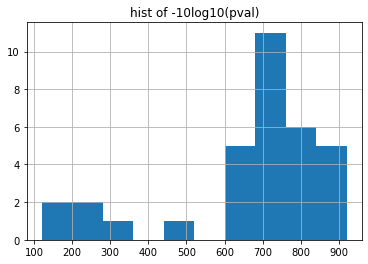

In [18]:
(-10*np.log10(mouse_res['pval'])).hist()
plt.title('hist of -10log10(pval)')

In [19]:
human_res = multiple_reg(mean_human, full_human)
human_res.head()

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,59.726346,4.012363,14.885579,1.225496e-49,51.861404,67.591287
E_10,61.248746,3.837877,15.959015,1.046602e-56,53.725826,68.771665
E_11,59.311525,3.941643,15.047412,1.128753e-50,51.585207,67.037843
E_12,62.654775,4.089091,15.322420,1.854171e-52,54.639432,70.670118
E_13,57.767353,3.907285,14.784526,5.365839e-49,50.108383,65.426323


Text(0.5, 1.0, 'hist of -10log10(pval)')

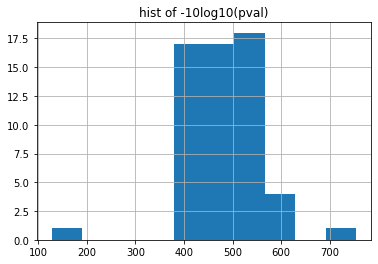

In [20]:
(-10*np.log10(human_res['pval'])).hist()
plt.title('hist of -10log10(pval)')

# Plot the distribution of the expression correlation matrix

In [21]:
def offdiag(corr):
    offdiag_idxs = np.where(~np.eye(corr.shape[0],dtype=bool))
    return corr[offdiag_idxs]

In [22]:
def sample_corr(expr):
    corr = np.corrcoef(expr, expr)[:expr.shape[0], :expr.shape[0]]
    return corr

In [23]:
def heatmap(expr):
    im = plt.imshow(np.abs(sample_corr(expr)))
    plt.colorbar(im)

In [24]:
def plot_corr(expr):
    corr_offdiag = offdiag(sample_corr(expr))
    _, bins, ax = plt.hist(corr_offdiag, bins=1000, density=True)
    plt.plot(bins, norm.pdf(bins, 0, 1/np.sqrt(expr.shape[1]-2)))
    plt.xlim(-1,1)

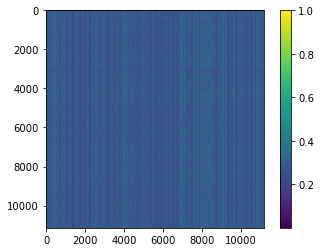

In [25]:
heatmap(mean_mouse.values)

In [64]:
np.mean(np.abs(offdiag(sample_corr(mean_mouse.values))))

0.27510197132158304

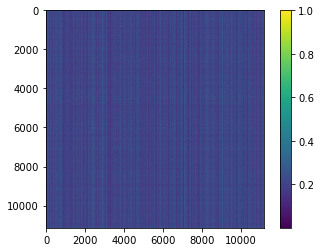

In [26]:
heatmap(mean_human.values)

In [65]:
np.mean(np.abs(offdiag(sample_corr(mean_human.values))))

0.2061004937068444

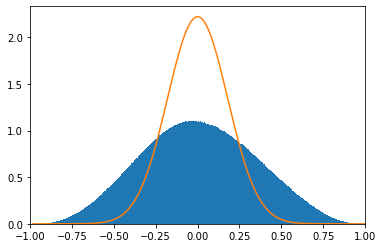

In [27]:
plot_corr(mean_mouse.values)

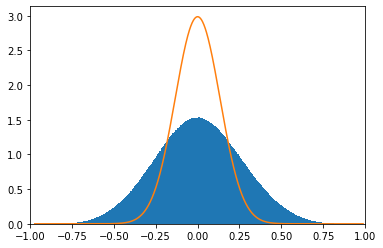

In [28]:
plot_corr(mean_human.values)

# Scale the gene expression values

Seems like there's some correlation. Can we reduce it by scaling the values?

In [29]:
def scale_expr(expr):
    return expr.subtract(expr.mean(axis=1), axis=0).divide(expr.std(axis=1), axis=0)

In [30]:
mouse_scaled = scale_expr(mean_mouse)
human_scaled = scale_expr(mean_human)
mouse_scaled.shape

(11139, 33)

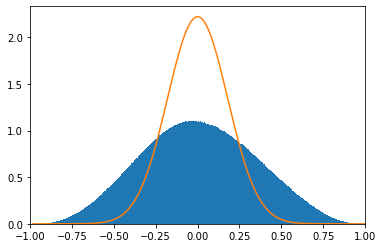

In [31]:
plot_corr(mouse_scaled)

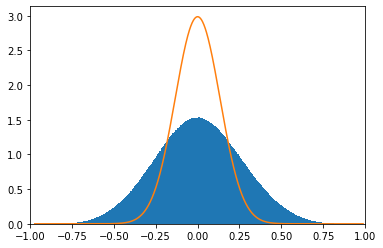

In [32]:
plot_corr(human_scaled)

# Correct for gene correlation by regressing out PCs

Let's first obtain the PCs of each expression matrix.

In [33]:
def marchenko_pastur_mu(x, rho, sigma2=1):
    x = np.atleast_1d(x).astype(float)
    rho_p = sigma2 * (1 + np.sqrt(rho)) ** 2
    rho_m = sigma2 * (1 - np.sqrt(rho)) ** 2
    mu = np.zeros_like(x)
    is_nonzero = (rho_m < x) & (x < rho_p)
    x_valid = x[is_nonzero]
    factor = 1 / (2 * np.pi * sigma2 * rho)
    mu[is_nonzero] = factor / x_valid
    mu[is_nonzero] *= np.sqrt((rho_p - x_valid) * (x_valid - rho_m))
    if rho > 1:
        mu[x == 0] = 1 - 1 / rho
    return mu

In [34]:
def get_PCs(expr):
    pca = decomposition.PCA(svd_solver='full')
    pca.fit(expr.T)
    exp_var = pca.explained_variance_
    plt.scatter(range(len(exp_var)), exp_var)
    return pca

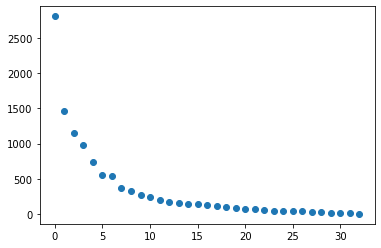

In [35]:
mouse_pca = get_PCs(mouse_scaled)

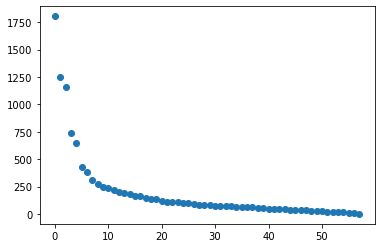

In [36]:
human_pca = get_PCs(human_scaled)

Seems like the first PC captures most of the variance.

In [37]:
def regress_PCs(pca, expr, num_PCs=4):
    transformed = pca.transform(expr.T)
    transformed[:,num_PCs:] = 0
    pc1_vals = pca.inverse_transform(transformed)
    return expr - pc1_vals.T

In [38]:
mouse_resid = regress_PCs(mouse_pca, mouse_scaled)
mouse_resid.shape

(11139, 33)

In [39]:
human_resid = regress_PCs(human_pca, human_scaled)
human_resid.shape

(11139, 58)

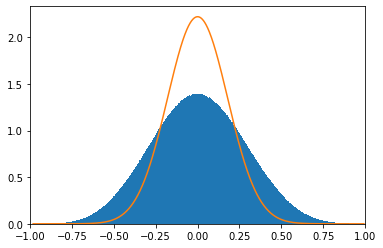

In [40]:
plot_corr(mouse_resid.values)

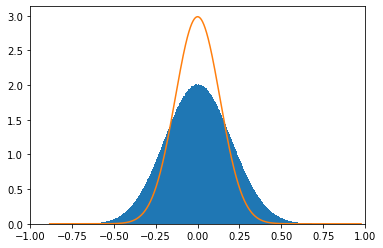

In [41]:
plot_corr(human_resid.values)

# Redo the regression with the residuals

In [42]:
def multiple_reg_pca(expr, full_expr, num_PCs=10):
    sumstats = {}
    resids = {}
    compnts = "+".join('C'+str(i) for i in range(num_PCs))
    for celltype in expr.columns:
        model = smf.ols(formula=f"{celltype} ~ auroc + "+compnts, data=full_expr)
        res = model.fit()
        resids[celltype] = res.resid
        sumstats[celltype] = res.summary2().tables[1].loc['auroc']
    sumstats = pd.DataFrame(sumstats).T
    resids = pd.DataFrame(resids)
    sumstats.index.names = ['celltype']
    resids.index.names = ['gene']
    resids.columns.names = ['celltype']
    sumstats.columns = ['beta', 'stderr', 't', 'pval', 'CI_start', 'CI_end']
    return sumstats, resids

In [43]:
def regress_w_components(expr, aurocs, species_pca, num_PCs=10):
    components = pd.DataFrame(species_pca.components_[:num_PCs,:].T)
    components.columns = ['C'+str(i) for i in range(len(components.columns))]
    components.index = aurocs.index
    full_df = pd.concat([merge_dfs(expr, aurocs), components], axis=1)
    return multiple_reg_pca(expr, full_df, num_PCs)

In [44]:
mouse_pca_res, mouse_pca_resid = regress_w_components(mean_mouse, aurocs, mouse_pca, num_PCs=mean_mouse.shape[1])
human_pca_res, human_pca_resid = regress_w_components(mean_human, aurocs, human_pca, num_PCs=mean_human.shape[1])
mouse_pca_res.head()

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,82.506506,4.002484,20.613823,1.107538e-92,74.660925,90.352087
E_10,76.658618,3.967179,19.323207,7.506946e-82,68.882243,84.434993
E_11,84.166451,4.152865,20.267083,1.041998e-89,76.026099,92.306803
E_12,73.264972,4.096597,17.884351,1.517898e-70,65.234914,81.295029
E_14,76.536614,3.969334,19.281978,1.624646e-81,68.756014,84.317214


(array([ 68.,  44., 126.,  54.,  30.,  30.,  78., 338., 170., 118.]),
 array([0.6016411 , 0.64062463, 0.67960816, 0.71859169, 0.75757522,
        0.79655875, 0.83554228, 0.87452581, 0.91350934, 0.95249287,
        0.9914764 ]),
 <BarContainer object of 10 artists>)

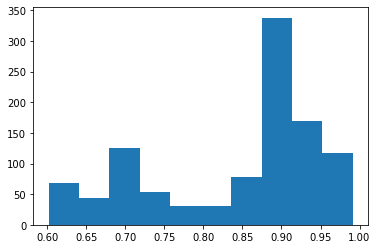

In [45]:
plt.hist(offdiag(np.corrcoef(mouse_pca_resid.T, mouse_pca_resid.T)[:mouse_pca_resid.shape[1], :mouse_pca_resid.shape[1]]))

Subset to just the significant celltypes.

In [46]:
alpha = 0.05

In [47]:
mouse_sig = mouse_pca_res[mouse_pca_res['pval'] < alpha]
human_sig = human_pca_res[human_pca_res['pval'] < alpha]
print(len(mouse_sig), len(human_sig)) # how many significant celltypes are there?

33 58


In [48]:
mouse_sig

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,82.506506,4.002484,20.613823,1.107538e-92,74.660925,90.352087
E_10,76.658618,3.967179,19.323207,7.506946e-82,68.882243,84.434993
E_11,84.166451,4.152865,20.267083,1.041998e-89,76.026099,92.306803
E_12,73.264972,4.096597,17.884351,1.517898e-70,65.234914,81.295029
E_14,76.536614,3.969334,19.281978,1.624646e-81,68.756014,84.317214
E_17,76.051717,4.015711,18.938545,9.502141e-79,68.180210,83.923223
E_2,74.987248,4.017375,18.665731,1.389527e-76,67.112479,82.862018
E_22,73.218097,3.997599,18.315517,7.570609e-74,65.382093,81.054102
E_3,72.067459,3.985687,18.081563,4.786574e-72,64.254803,79.880114


In [49]:
human_sig

,beta,stderr,t,pval,CI_start,CI_end
celltype,,,,,,
E_1,59.497887,4.016472,14.813471,3.538197e-49,51.624887,67.370887
E_10,61.001251,3.842780,15.874250,3.963740e-56,53.468718,68.533784
E_11,59.038869,3.945679,14.962918,3.955463e-50,51.304635,66.773102
E_12,62.402683,4.095800,15.235773,6.861064e-52,54.374185,70.431181
E_13,57.483619,3.913367,14.689045,2.158272e-48,49.812724,65.154515
E_14,61.951008,3.859705,16.050710,2.498365e-57,54.385299,69.516718
E_15,63.246567,3.904017,16.200383,2.342016e-58,55.593999,70.899135
E_17,59.930019,3.999156,14.985667,2.828420e-50,52.090961,67.769077
E_18,58.843228,3.866995,15.216784,9.118197e-52,51.263229,66.423227


In [50]:
mouse_pca_res.to_csv(mouse_results_out, sep='\t')

In [53]:
human_pca_res.to_csv(human_results_out, sep='\t')

Which of the significant celltypes are shared between species?

In [54]:
set(mouse_sig.index).intersection(human_sig.index)

{'E_1',
 'E_10',
 'E_11',
 'E_12',
 'E_14',
 'E_17',
 'E_2',
 'E_22',
 'E_3',
 'E_4',
 'E_5',
 'E_6',
 'E_7',
 'E_8',
 'E_9',
 'I_1',
 'I_10',
 'I_12',
 'I_13',
 'I_17',
 'I_21',
 'I_25',
 'I_3',
 'I_4',
 'I_5',
 'I_7',
 'I_8',
 'N_1'}

# Correct for multiple hypothesis testing
Let's perform an FDR correction.

First, let's plot the distribution of the t-statistics.

<AxesSubplot:>

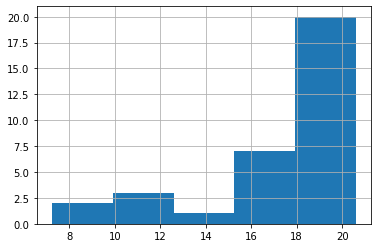

In [55]:
mouse_pca_res['t'].hist(bins=5)

<AxesSubplot:>

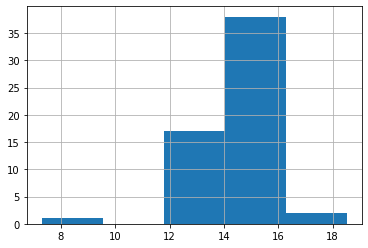

In [56]:
human_pca_res['t'].hist(bins=5)